# NLP — Regular expressions

Piotr Janczyk

In [1]:
from glob import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

%matplotlib inline
%config InlineBackend.figure_format='svg'

## Loading data and preprocessing

Load texts of acts from files and perform some basic normalization.

In [2]:
def read_file(filename: str) -> str:
    with open(filename, 'r') as f:
        return f.read()

def normalize_text(text: str) -> str:
    # Remove non-breaking space and soft-hypen characters
    text = text.replace("\xa0", " ").replace("\xad", "")
    # Replace sequences of whitespace characters with single space
    # to avoid having to use `\s+` or `re.DOTALL`
    text = re.sub(r"\s+", " ", text)
    # Convert to lowercase to avoid having to use `re.IGNORECASE`
    text = text.lower()
    return text

filenames = sorted(glob("ustawy/*.txt"))

acts = pd.DataFrame({
  "id": [re.match(r"ustawy/(\d+_\d+)\.txt", filename).group(1) for filename in filenames],
  "year": [re.match(r"ustawy/(\d+)_\d+\.txt", filename).group(1) for filename in filenames],
  "text": [normalize_text(read_file(filename)) for filename in filenames]
})

acts.head()

,id,year,text
0,1993_599,1993,"dz.u. z 1993 r. nr 129, poz. 599 ustawa z dni..."
1,1993_602,1993,"dz.u. z 1993 r. nr 129, poz. 602 ustawa z dni..."
2,1993_645,1993,"dz.u. z 1993 r. nr 134, poz. 645 ustawa z dni..."
3,1993_646,1993,"dz.u. z 1993 r. nr 134, poz. 646 ustawa z dni..."
4,1994_150,1994,"dz.u. z 1994 r. nr 40, poz. 150 ustawa z dnia..."


In [3]:
all_texts = " ".join(acts["text"])

## Computing number of different types of amendments

Use regular expressions to find phrases related to different types of amendments.

In [4]:
unit_pattern = "(?:" + "|".join([
  r"\bart\b",
  r"\bust\b",
  r"\busta\b",
  r"\bpkt\b",
  r"\blit",
  r"\blitery\b",
  r"\brozdziały?\b",
  r"\btytuł\b",
  r"\bzałącznik\b",
  r"\bdział\b",
  r"\btiret\b",
  r"\bpoz\b",
  r"\bpozycję\b",
  r"\boddział\b",
  r"\blp\b",
  r"\bodnośnik\b",
  r"\boznaczenie\b",
  r"\bcyfrę\b",
  r"\btytuł\b",
  r"§",
  r"\b\d+\b",
  r"\b\d+\.",
  r"\b\d+[a-z]\b",
  r"\b[a-z]\b",
  r"\b[a-z]\)",
  r"\{\d+\}",   
]) + ")"

def find_unit_additions(text: str) -> List[re.Match]:
    matches = []
    for m in re.finditer(r"\bdodaje się\b(.{,15})\bw brzmieniu\b", text):
        context = m.group(1)
        if re.search(unit_pattern, context):
            # e.g. "dodaje się art. 123 w brzmieniu"
            matches.append(m)
        else:
            # e.g. "dodaje się wyrazy w brzmieniu"
            pass
    return matches

def find_unit_removals(text: str) -> List[re.Match]:
    matches = []
    for m in re.finditer(r"\bskreśla się\b", text):
        context_before = m.string[m.start() - 20:m.start()]
        context_after = m.string[m.end():m.end() + 20]

        if re.search(r"^ (w )?" + unit_pattern, context_after):
            # e.g. "skreśla się art. 123"
            matches.append(m)
        elif re.search(unit_pattern + r" $", context_before) and re.search(r"^[\.,;]", context_after):
            # e.g. "art. 123 skreśla się."
            matches.append(m)
        else:
            # e.g. "w art. 123 skreśla się wyrazy"
            pass
    return matches

def find_unit_changes(text: str) -> List[re.Match]:
    matches = []
    for m in re.finditer(r"\botrzymuj(?:e|ą) brzmienie\b", text):
        context_before = m.string[m.start() - 20:m.start()]
        if re.search(unit_pattern + r" $", context_before):
            # e.g. "art. 123 otrzymuje brzmienie"
            matches.append(m)
        else:
            # e.g. "zdanie pierwsze otrzymuje brzmienie"
            pass
    return matches

Count number of amendments in each act.

In [5]:
amendments = pd.DataFrame({
    "id": acts["id"],
    "year": acts["year"],
    "unit_additions": [len(find_unit_additions(text)) for text in acts["text"]],
    "unit_removals": [len(find_unit_removals(text)) for text in acts["text"]],
    "unit_changes": [len(find_unit_changes(text)) for text in acts["text"]],
})

amendments.head()

,id,year,unit_additions,unit_removals,unit_changes
0,1993_599,1993,10,2,19
1,1993_602,1993,1,0,9
2,1993_645,1993,0,0,0
3,1993_646,1993,23,4,35
4,1994_150,1994,0,1,1


Group results by year and convert to percentages.

In [6]:
amendments_by_year = amendments.groupby("year").sum()
totals = amendments_by_year[["unit_additions", "unit_removals", "unit_changes"]].sum(axis=1)
amendments_by_year["unit_additions"] *= 100 / totals
amendments_by_year["unit_removals"] *= 100 / totals
amendments_by_year["unit_changes"] *= 100 / totals

amendments_by_year

,unit_additions,unit_removals,unit_changes
year,,,
1993,33.009709,5.825243,61.165049
1994,31.791908,13.583815,54.624277
1995,40.399002,11.845387,47.755611
1996,30.096502,14.897467,55.006031
1997,31.861804,15.307102,52.831094
1998,34.693878,15.698587,49.607535
1999,39.130435,15.942029,44.927536
2000,28.625235,12.994350,58.380414
2001,37.964237,11.382393,50.653370


Plot chart.

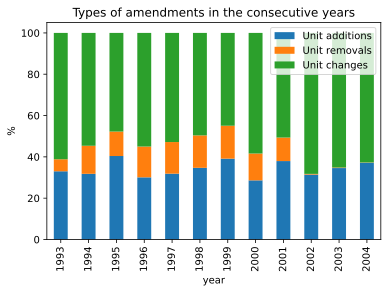

In [7]:
ax = amendments_by_year.plot.bar(
    stacked=True,
    title="Types of amendments in the consecutive years",
    ylabel="%")
ax.legend(["Unit additions", "Unit removals", "Unit changes"]);

## Computing number of occurrences of the word 'ustawa' in various contexts

Define regular expression for each phrase.

In [8]:
act_forms = [
  "ustawa", "ustawy",
  "ustawy", "ustaw",
  "ustawie", "ustawom",
  "ustawę", "ustawy",
  "ustawą", "ustawami",
  "ustawie", "ustawach",
  "ustawo", "ustawy",
]
act_pattern = "(?:" + "|".join([r"\b" + re.escape(form) + r"\b" for form in act_forms]) + ")"
act_of_date_pattern = act_pattern + r" z dnia\b"
act_not_of_date_pattern = act_pattern + r"(?! z dnia\b)"
act_not_about_change_pattern = act_pattern + r"(?! o zmianie\b)"

def count_pattern(pattern: str, text: str) -> int:
    return len(re.findall(pattern, text))
def count_act(text: str) -> int:
    return count_pattern(act_pattern, text)
def count_act_of_date(text: str) -> int:
    return count_pattern(act_of_date_pattern, text)
def count_act_not_of_date(text: str) -> int:
    return count_pattern(act_not_of_date_pattern, text)
def count_act_not_about_change(text: str) -> int:
    return count_pattern(act_not_about_change_pattern, text)

Compute total number of occurences.

In [9]:
pd.DataFrame(
    data = [
        count_act(all_texts),
        count_act_of_date(all_texts),
        count_act_not_of_date(all_texts),
        count_act_not_about_change(all_texts)
    ],
    index = [
        "'ustawa'",
        "'ustawa' followed by 'z dnia'",
        "'ustawa' not followed by 'z dnia'",
        "'ustawa' not followed by 'o zmianie'"
    ],
    columns = ["Number of occurences"]
)

,Number of occurences
'ustawa',25095
'ustawa' followed by 'z dnia',8638
'ustawa' not followed by 'z dnia',16457
'ustawa' not followed by 'o zmianie',25061


In [10]:
count_act(all_texts) == count_act_of_date(all_texts) + count_act_not_of_date(all_texts)

True

Compute number of occurences in each act.

In [11]:
phrases = pd.DataFrame({
    "id": acts["id"],
    "year": acts["year"],
    "act_count": [count_act(text) for text in acts["text"]],
    "act_of_date_count": [count_act_of_date(text) for text in acts["text"]],
    "act_not_of_date_count": [count_act_not_of_date(text) for text in acts["text"]],
    "act_not_about_change_count": [count_act_not_about_change(text) for text in acts["text"]],
})
phrases.head()

,id,year,act_count,act_of_date_count,act_not_of_date_count,act_not_about_change_count
0,1993_599,1993,15,4,11,15
1,1993_602,1993,8,5,3,8
2,1993_645,1993,4,2,2,4
3,1993_646,1993,41,11,30,41
4,1994_150,1994,4,2,2,4


Group results by year.

In [12]:
phrases_by_year = phrases.groupby("year").sum()
phrases_by_year

,act_count,act_of_date_count,act_not_of_date_count,act_not_about_change_count
year,,,,
1993,68,22,46,68
1994,637,170,467,635
1995,1018,294,724,1017
1996,1911,622,1289,1905
1997,3457,1074,2383,3455
1998,772,212,560,771
1999,836,310,526,834
2000,2240,833,1407,2237
2001,4139,1311,2828,4137


Plot chart.

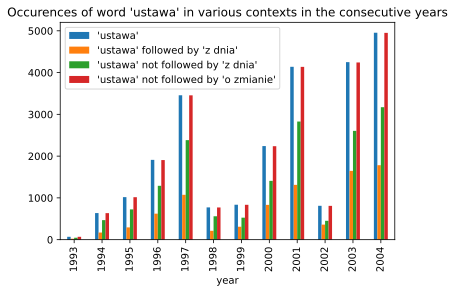

In [13]:
ax = phrases_by_year.plot.bar(
    title="Occurences of word 'ustawa' in various contexts in the consecutive years")
ax.legend([
    "'ustawa'",
    "'ustawa' followed by 'z dnia'",
    "'ustawa' not followed by 'z dnia'",
    "'ustawa' not followed by 'o zmianie'",
]);